In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import math
import numpy as np

In [2]:
df = pd.read_csv("../data/processed/qtd_vendas_diaria.csv")

In [3]:
print(df.shape)
df.head()

(1783, 2)


,Unnamed: 0,NUMERO_NOTA_FISCAL
0,2015-02-02,0
1,2015-02-03,0
2,2015-02-04,0
3,2015-02-05,0
4,2015-02-06,0


In [4]:
df = df.rename(columns={"Unnamed: 0": "data","NUMERO_NOTA_FISCAL":"qtd_vendas"})
df.tail()

,data,qtd_vendas
1778,2019-12-16,0
1779,2019-12-17,0
1780,2019-12-18,0
1781,2019-12-19,0
1782,2019-12-20,1


In [5]:
df = df.loc[df.data < '2019-05-01']
df.index = df.data

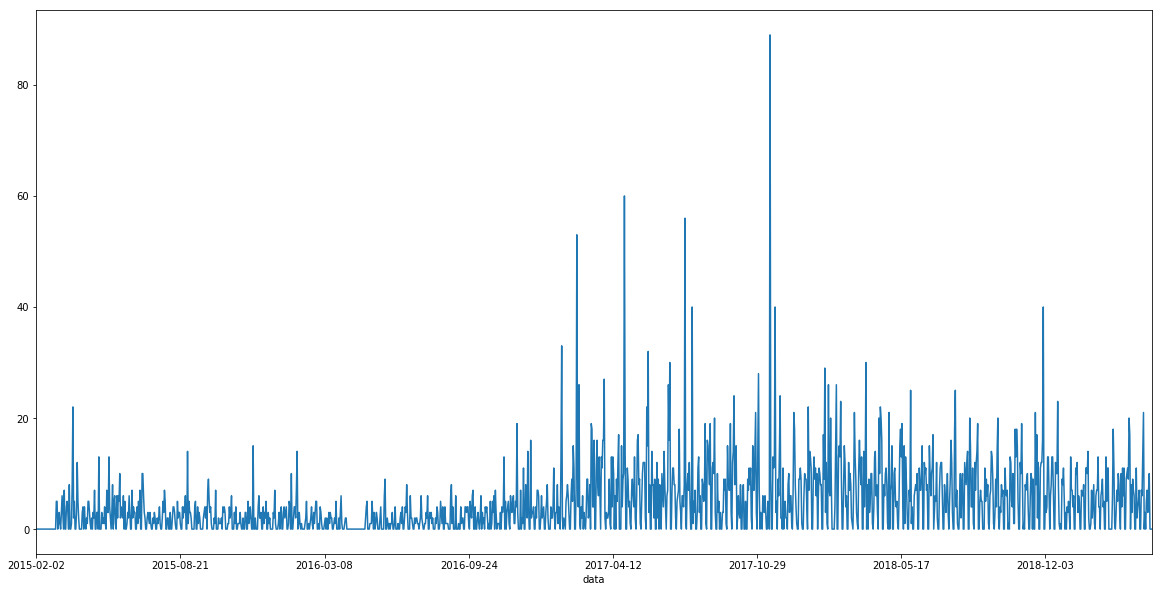

In [6]:
df.qtd_vendas.plot.line(figsize=(20,10))

### Feature engineering

In [7]:
df.data = pd.to_datetime(df.data)

In [8]:
df['dayofmonth'] = df.data.dt.day
df['dayofweek'] = df.data.dt.dayofweek
df['month'] = df.data.dt.month
df['year'] = df.data.dt.year
df.head()

,data,qtd_vendas,dayofmonth,dayofweek,month,year
data,,,,,,
2015-02-02,2015-02-02,0,2,0,2,2015
2015-02-03,2015-02-03,0,3,1,2,2015
2015-02-04,2015-02-04,0,4,2,2,2015
2015-02-05,2015-02-05,0,5,3,2,2015
2015-02-06,2015-02-06,0,6,4,2,2015


In [9]:
df['small_MA'] = df.qtd_vendas.rolling(window=20).mean()
df['big_MA'] = df.qtd_vendas.rolling(window=30).mean()

In [10]:
# retira os primeiros registros após o shift, pois esses possuem NaN em suas colunas
df.dropna(inplace=True)
df.head()

,data,qtd_vendas,dayofmonth,dayofweek,month,year,small_MA,big_MA
data,,,,,,,,
2015-03-03,2015-03-03,5,3,1,3,2015,0.50,0.333333
2015-03-04,2015-03-04,0,4,2,3,2015,0.50,0.333333
2015-03-05,2015-03-05,1,5,3,3,2015,0.55,0.366667
2015-03-06,2015-03-06,3,6,4,3,2015,0.70,0.466667
2015-03-07,2015-03-07,1,7,5,3,2015,0.75,0.500000


In [11]:
reg = RandomForestRegressor(max_depth = 5, n_estimators = 100)

### Split do dataset

In [12]:
X = df.drop(['data','qtd_vendas'],axis=1)
y = df[['qtd_vendas']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=6)
print("X_train shape:",X_train.shape,"X_test shape:", X_test.shape)

X_train shape: (1216, 6) X_test shape: (304, 6)


In [13]:
reg.fit(X_train, y_train)

/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [14]:
trainPredict = reg.predict(X_train)
testPredict = reg.predict(X_test)

In [15]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, testPredict))

# RMSE
print("Root Mean squared error: %.2f"
      % math.sqrt(mean_squared_error(y_test, testPredict)))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, testPredict))

Mean squared error: 14.36
Root Mean squared error: 3.79
R2 score: 0.61


In [16]:
total_predicts = np.concatenate((trainPredict,testPredict))
for i in range(len(trainPredict)):
    testPredict = np.insert(testPredict, 0, [np.NaN])

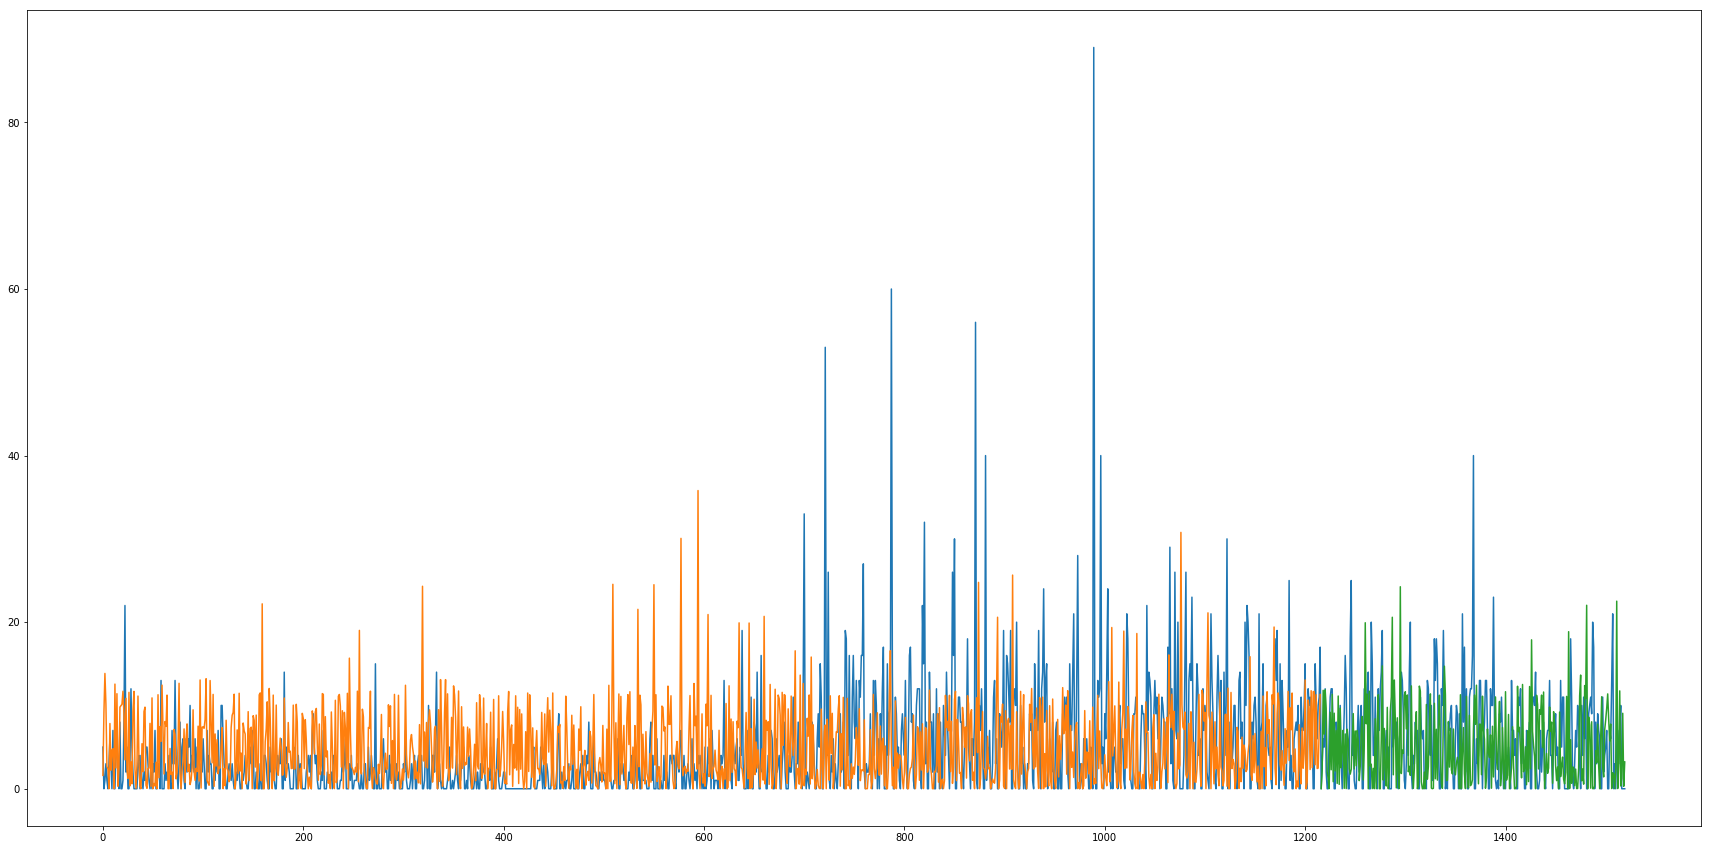

In [19]:
# plot baseline and predictions
plt.plot(df.qtd_vendas.values)
plt.plot(trainPredict)
plt.plot(testPredict)
plt.rcParams['figure.figsize'] = [30, 15]
plt.show()

In [21]:
len(total_predicts)

1520

In [23]:
df['qtd_vendas_previstas'] = total_predicts

In [25]:
df.to_csv("../data/processed/forecast_vendas_carros.csv")